![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 4 - Deep Learning Basics</center>
### <center> Optimization Methods (SGDM & Adam)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/04_OptimizationMethods/MainOptimization1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

In [4]:
#-- What we have so far:
from DeepLearningFramework.Layers        import LinearLayer, ReLULayer
from DeepLearningFramework.Models        import SequentialModel
from DeepLearningFramework.LossFunctions import CrossEntropyLoss
from DeepLearningFramework.Dataset       import Dataset
from DeepLearningFramework.Auxiliary     import Accuracy, Plot, Recorder

### Get Fashion MNIST dataset

In [5]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
mX.shape, vY.shape, lClasses

((60000, 784),
 (60000,),
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

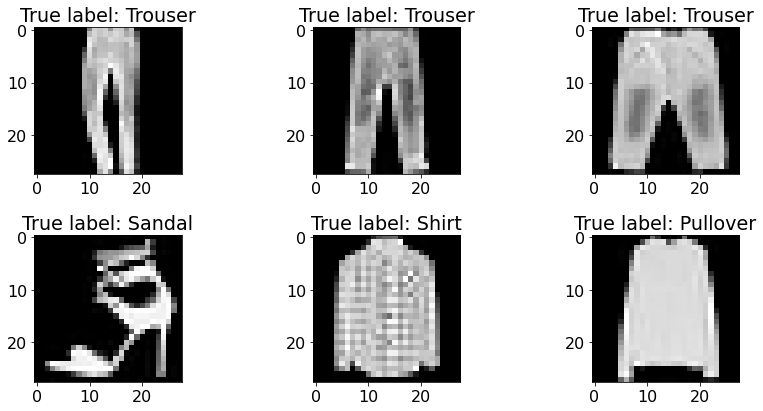

In [6]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vY[idx]]))
    
plt.tight_layout()
plt.show()

###  Normalize data:

In [7]:
vMean = np.mean(mX, axis=0)
vStd  = np.std(mX, axis=0)
mX    = (mX - vMean) / vStd

###  Split to train and validation:

In [8]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((55000, 784), (55000,), (5000, 784), (5000,))

### A basic optimizer (only SGD):

In [9]:
#-- Basic gradient descent update rule:
class Sgd:
    def __init__(self, lr=1e-3):
        self.lr = lr
        
    def Step(self, mW, mDw, dState={}):
        mW -= self.lr * mDw
        return mW, dState

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Optimizer:
    def __init__(self, oUpdateRule):
        self.oUpdateRule = oUpdateRule #-- SGD, SGDM, ADAM
        self.dStates     = {}
            
    def Step(self, oModel, lr=None):
        
        if lr is not None:
            self.oUpdateRule.lr = lr
        
        for ii, oLayer in enumerate(oModel.lLayers):
            for sParam in oLayer.dGrads:
                #-- Get param, gradient and history:
                mW          = oLayer.dParams[sParam]
                mDw         = oLayer.dGrads[sParam]
                sLayerParam = str(ii) + sParam
                dState      = self.dStates.get(sLayerParam, {})
                
                #-- Apply step:
                mW, dState                = self.oUpdateRule.Step(mW, mDw, dState)
                
                #-- Set param and hisoty:
                oLayer.dParams[sParam]    = mW
                self.dStates[sLayerParam] = dState

### Define the training loop with optimizer:

In [10]:
import time
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainLoop(oModel, oTrainData, oOptim):
    
    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters
        oOptim.Step(oModel)
            
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
    
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData):
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
    
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

In [11]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, oOptim):
   
    oRecorder = Recorder([
        Plot('Loss',       'train', 'epoch', 'b'),
        Plot('Loss',       'val',   'epoch', 'r'),
        Plot('Accuracy',   'train', 'epoch', 'b'),
        Plot('Accuracy',   'val',   'epoch', 'r'),
    ])

    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, oOptim)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('Accuracy', 'train', trainAcc),
        oRecorder.Append('Accuracy', 'val',   valAcc),
        oRecorder.Draw()
        
        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')
        

###  Learning rate sweep (with an optimizer):

In [12]:
def LearningRateSweep(oModel, oTrainData, oOptim, vLearningRate):
   
    #-- Record mini-batches loss:
    oRecorder = Recorder([
        Plot('Batch loss', 'train', 'learning rate', 'b'),
    ])

    numIter = len(vLearningRate)
    ii      = 0
    while ii < numIter:
        #-- Iterate over the mini-batches:
        for mX, vY in oTrainData:
            if ii >= numIter:
                break
                
            #-- Forward:
            mZ        = oModel.Forward(mX)
            loss, mDz = CrossEntropyLoss(vY, mZ)

            #-- Backward:
            oModel.Backward(mDz)

            #-- Update parameters (with new learning rate)
            oOptim.Step(oModel, vLearningRate[ii])

            oRecorder.Append('Batch loss', 'train', loss)
            oRecorder.Draw()        
        
            ii += 1
            
    #-- Display:
    ax = oRecorder.dAxes['Batch loss']
    ax.lines[0].set_xdata(vLearningRate)
    ax.axis(xmin=vLearningRate[0], xmax=vLearningRate[-1])
    ax.set_xscale('log')
    oRecorder.Draw()

###  Define a model:

In [13]:
def GetModel():
    oModel = SequentialModel([
        LinearLayer(784, 500),
        ReLULayer(),
        LinearLayer(500, 250),
        ReLULayer(),
        LinearLayer(250, 150),
        ReLULayer(),
        LinearLayer(150, 100),
        ReLULayer(),
        LinearLayer(100,  10),
    ])
    
    return oModel

###  Search for a learning rate:

In [14]:
batchSize     = 8192
oTrainSet     = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet       = Dataset(mValX.T,   vValY,  batchSize)

<IPython.core.display.Javascript object>


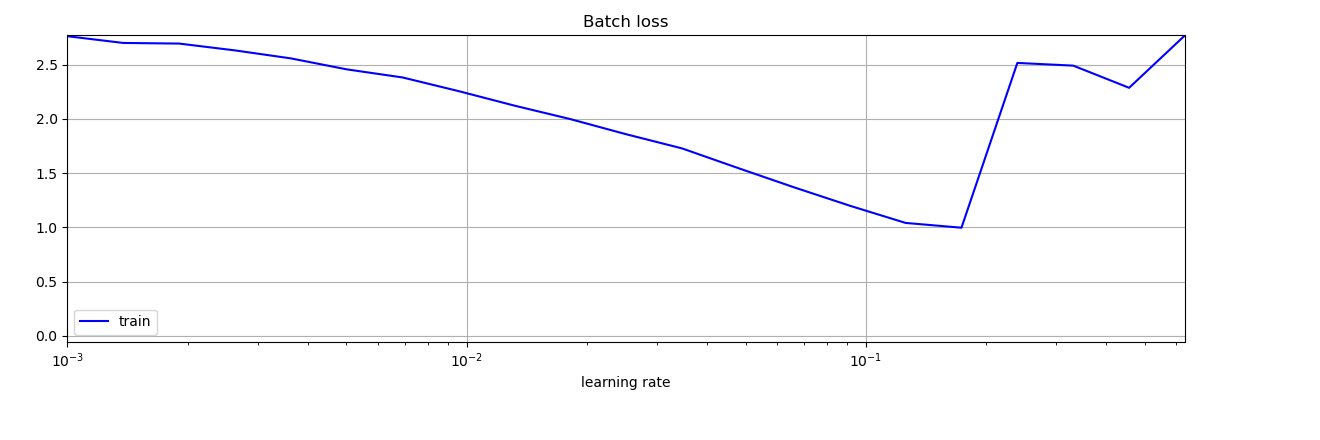

In [15]:
%matplotlib notebook

oModel        = GetModel()
vLearningRate = np.logspace(-3, -0.2, 21)
oOptim        = Optimizer(Sgd())
LearningRateSweep(oModel, oTrainSet, oOptim, vLearningRate)

<IPython.core.display.Javascript object>


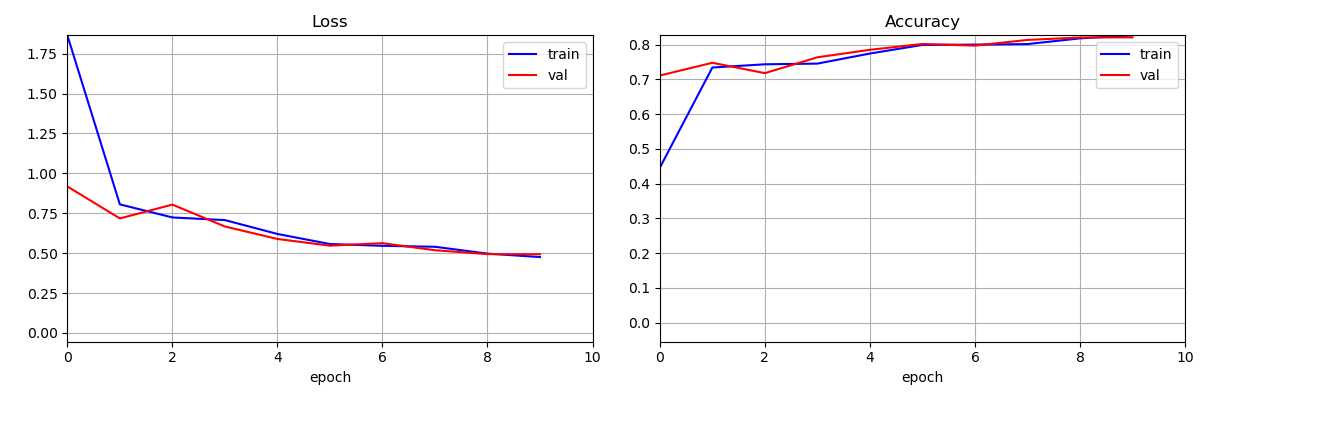

Epoch   0: | Train loss: 1.86501 | Val loss: 0.91810 | Train Accuracy: 0.4460 | Val Accuracy: 0.7114 | epoch time: 3.548 |
Epoch   1: | Train loss: 0.80575 | Val loss: 0.71756 | Train Accuracy: 0.7344 | Val Accuracy: 0.7480 | epoch time: 3.502 |
Epoch   2: | Train loss: 0.72375 | Val loss: 0.80422 | Train Accuracy: 0.7437 | Val Accuracy: 0.7182 | epoch time: 3.671 |
Epoch   3: | Train loss: 0.70718 | Val loss: 0.66712 | Train Accuracy: 0.7457 | Val Accuracy: 0.7638 | epoch time: 4.087 |
Epoch   4: | Train loss: 0.62033 | Val loss: 0.58899 | Train Accuracy: 0.7746 | Val Accuracy: 0.7854 | epoch time: 3.881 |
Epoch   5: | Train loss: 0.55725 | Val loss: 0.54687 | Train Accuracy: 0.7995 | Val Accuracy: 0.8022 | epoch time: 3.865 |
Epoch   6: | Train loss: 0.54593 | Val loss: 0.56258 | Train Accuracy: 0.8003 | Val Accuracy: 0.7974 | epoch time: 3.885 |
Epoch   7: | Train loss: 0.54002 | Val loss: 0.51829 | Train Accuracy: 0.8019 | Val Accuracy: 0.8138 | epoch time: 3.788 |
Epoch   8: | Tra

In [16]:
%matplotlib notebook

oModel = GetModel()
oOptim = Optimizer(Sgd(lr=1e-1))
TrainModel(oModel, oTrainSet, oValSet, 10, oOptim)

### SGDM and Adam implementations:

In [17]:
class Sgdm:
    def __init__(self, lr=1e-3, beta=0.9):
        self.lr   = lr
        self.beta = beta
        
    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mV            = self.beta * mV - self.lr * mDw
        mW           += mV
        dState['mV']  = mV
        
        return mW, dState
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#    
class Adam:
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.99, eps=1e-8):
        self.lr    = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps   = eps
        
    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mS            = dState.get('mS', np.zeros(mW.shape))
        ii            = dState.get('ii', 0) + 1
        
        mV            = self.beta1 * mV + (1 - self.beta1) * mDw
        mS            = self.beta2 * mS + (1 - self.beta2) * mDw * mDw
        
        mTildeV       = mV / (1 - self.beta1**ii)
        mTildeS       = mS / (1 - self.beta2**ii)
        
        mW           -= self.lr * mTildeV / (np.sqrt(mTildeS) + self.eps)
        dState['mV']  = mV
        dState['mS']  = mS
        dState['ii']  = ii
        
        return mW, dState

### Train the same architecture with SGDM:

<IPython.core.display.Javascript object>


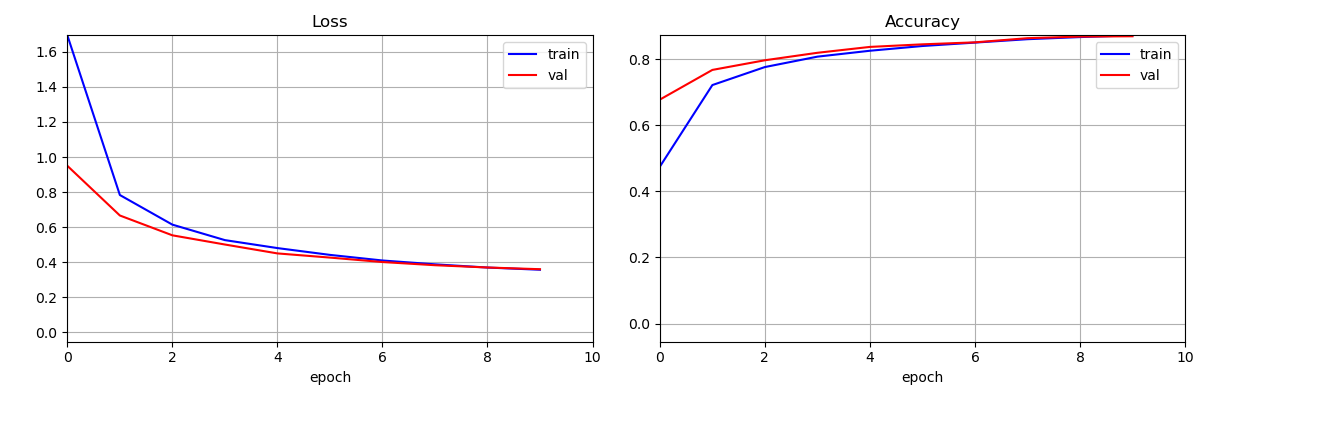

Epoch   0: | Train loss: 1.69494 | Val loss: 0.94969 | Train Accuracy: 0.4746 | Val Accuracy: 0.6774 | epoch time: 3.878 |
Epoch   1: | Train loss: 0.78291 | Val loss: 0.66596 | Train Accuracy: 0.7214 | Val Accuracy: 0.7672 | epoch time: 3.889 |
Epoch   2: | Train loss: 0.61373 | Val loss: 0.55272 | Train Accuracy: 0.7759 | Val Accuracy: 0.7964 | epoch time: 3.811 |
Epoch   3: | Train loss: 0.52532 | Val loss: 0.50021 | Train Accuracy: 0.8073 | Val Accuracy: 0.8190 | epoch time: 3.714 |
Epoch   4: | Train loss: 0.47985 | Val loss: 0.44939 | Train Accuracy: 0.8252 | Val Accuracy: 0.8368 | epoch time: 3.735 |
Epoch   5: | Train loss: 0.44099 | Val loss: 0.42553 | Train Accuracy: 0.8395 | Val Accuracy: 0.8446 | epoch time: 4.160 |
Epoch   6: | Train loss: 0.40895 | Val loss: 0.40015 | Train Accuracy: 0.8499 | Val Accuracy: 0.8506 | epoch time: 4.322 |
Epoch   7: | Train loss: 0.38702 | Val loss: 0.38197 | Train Accuracy: 0.8601 | Val Accuracy: 0.8632 | epoch time: 3.971 |
Epoch   8: | Tra

In [18]:
%matplotlib notebook

oModel = GetModel()
oOptim = Optimizer(Sgdm(lr=5e-2, beta=0.9))
TrainModel(oModel, oTrainSet, oValSet, 10, oOptim)

#### Question:
Which optimizer obtains a better performance after 10 iterations?

### Lets us try Adam:

<IPython.core.display.Javascript object>


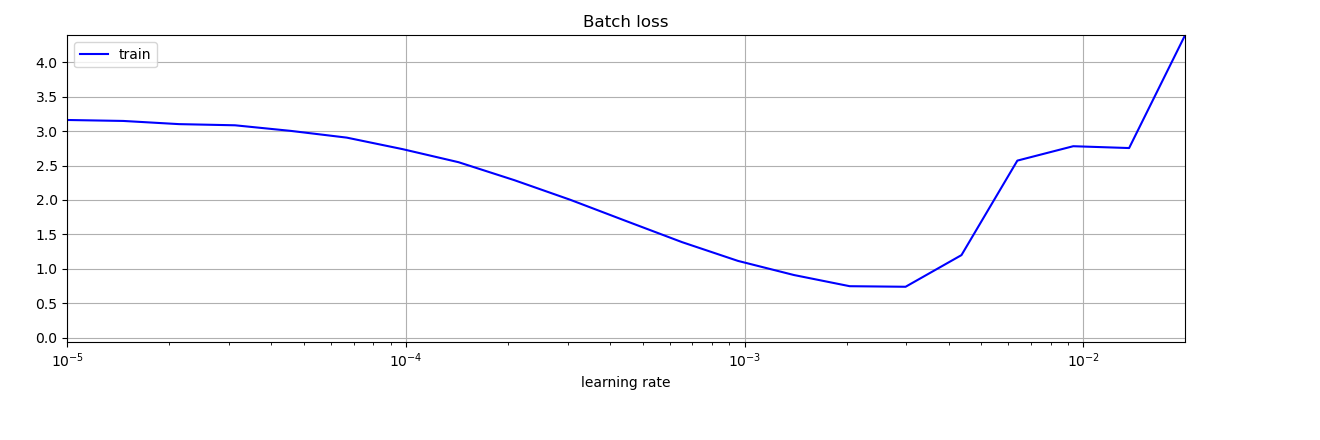

In [19]:
%matplotlib notebook

oModel        = GetModel()
oOptim        = Optimizer(Adam(lr=0, beta1=0.7, beta2=0.8))
vLearningRate = np.logspace(-5, -1.7, 21)
LearningRateSweep(oModel, oTrainSet, oOptim, vLearningRate)

<IPython.core.display.Javascript object>


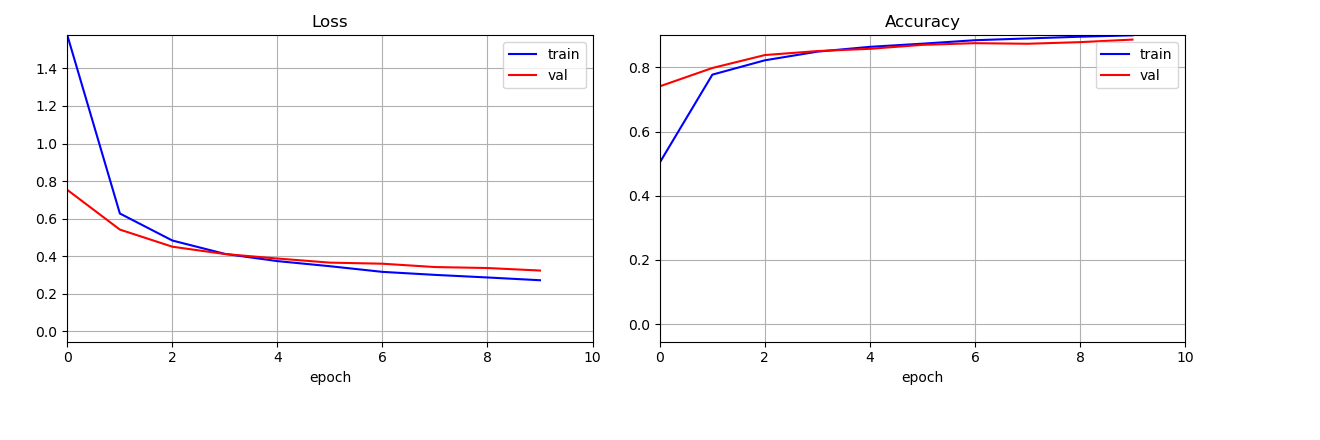

Epoch   0: | Train loss: 1.57617 | Val loss: 0.75323 | Train Accuracy: 0.5039 | Val Accuracy: 0.7412 | epoch time: 4.283 |
Epoch   1: | Train loss: 0.62765 | Val loss: 0.54197 | Train Accuracy: 0.7775 | Val Accuracy: 0.7982 | epoch time: 4.100 |
Epoch   2: | Train loss: 0.48373 | Val loss: 0.45082 | Train Accuracy: 0.8222 | Val Accuracy: 0.8386 | epoch time: 4.231 |
Epoch   3: | Train loss: 0.41267 | Val loss: 0.41180 | Train Accuracy: 0.8492 | Val Accuracy: 0.8510 | epoch time: 3.995 |
Epoch   4: | Train loss: 0.37420 | Val loss: 0.38786 | Train Accuracy: 0.8642 | Val Accuracy: 0.8580 | epoch time: 4.179 |
Epoch   5: | Train loss: 0.34701 | Val loss: 0.36612 | Train Accuracy: 0.8740 | Val Accuracy: 0.8704 | epoch time: 3.960 |
Epoch   6: | Train loss: 0.31687 | Val loss: 0.36029 | Train Accuracy: 0.8848 | Val Accuracy: 0.8756 | epoch time: 4.071 |
Epoch   7: | Train loss: 0.30089 | Val loss: 0.34256 | Train Accuracy: 0.8904 | Val Accuracy: 0.8738 | epoch time: 4.308 |
Epoch   8: | Tra

In [20]:
%matplotlib notebook

oModel = GetModel()
oOptim = Optimizer(Adam(lr=1e-3, beta1=0.7, beta2=0.8))
TrainModel(oModel, oTrainSet, oValSet, 10, oOptim)

### Let us overfit the training data:

<IPython.core.display.Javascript object>


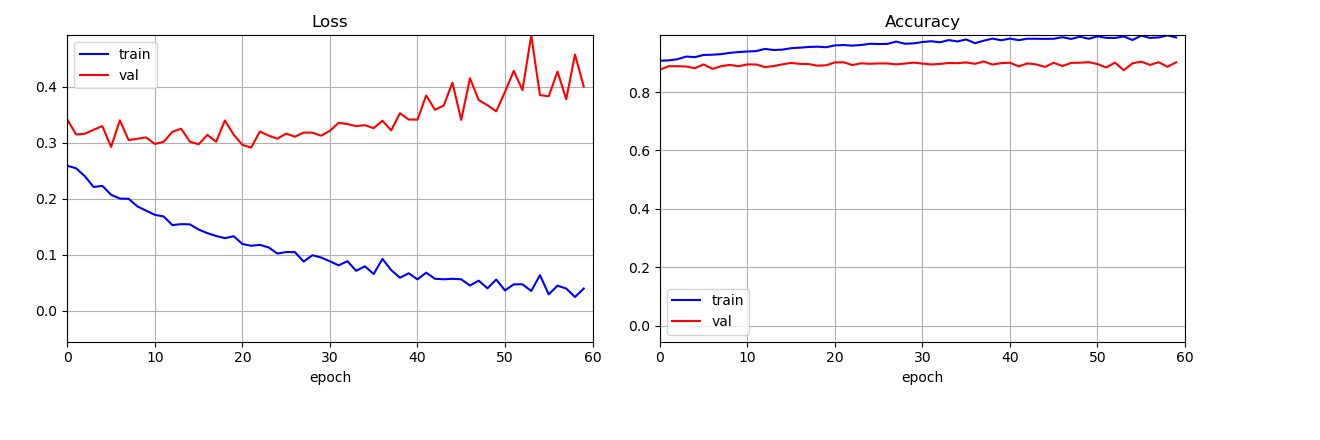

Epoch   0: | Train loss: 0.25888 | Val loss: 0.34122 | Train Accuracy: 0.9072 | Val Accuracy: 0.8762 | epoch time: 3.867 |
Epoch   1: | Train loss: 0.25440 | Val loss: 0.31473 | Train Accuracy: 0.9083 | Val Accuracy: 0.8884 | epoch time: 3.888 |
Epoch   2: | Train loss: 0.24024 | Val loss: 0.31606 | Train Accuracy: 0.9123 | Val Accuracy: 0.8884 | epoch time: 3.937 |
Epoch   3: | Train loss: 0.22104 | Val loss: 0.32306 | Train Accuracy: 0.9215 | Val Accuracy: 0.8874 | epoch time: 3.663 |
Epoch   4: | Train loss: 0.22301 | Val loss: 0.32961 | Train Accuracy: 0.9195 | Val Accuracy: 0.8816 | epoch time: 3.902 |
Epoch   5: | Train loss: 0.20719 | Val loss: 0.29251 | Train Accuracy: 0.9269 | Val Accuracy: 0.8946 | epoch time: 3.986 |
Epoch   6: | Train loss: 0.20039 | Val loss: 0.33997 | Train Accuracy: 0.9278 | Val Accuracy: 0.8792 | epoch time: 3.731 |
Epoch   7: | Train loss: 0.19994 | Val loss: 0.30471 | Train Accuracy: 0.9298 | Val Accuracy: 0.8886 | epoch time: 3.807 |
Epoch   8: | Tra

In [21]:
%matplotlib notebook

TrainModel(oModel, oTrainSet, oValSet, 60, oOptim)

### Apply model to test data:

Test accuracy:88.3%


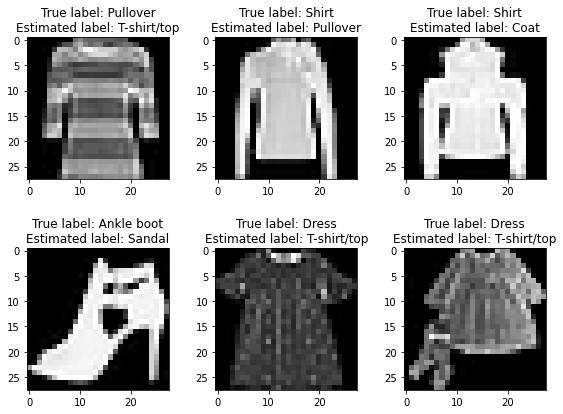

In [22]:
%matplotlib inline

oTorchTestSet = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
mTestX        = oTorchTestSet.data.view(-1,784).numpy() / 255
mTestX        = (mTestX - vMean) / vStd
vTestY        = oTorchTestSet.targets.numpy()

#-- Apply model to data:
mHatTestY = oModel.Forward(mTestX.T)
print('Test accuracy:' + str(100 * Accuracy(mHatTestY, vTestY)) + '%')

#-- Plot a few mistakes:
vHatTestY = np.argmax(mHatTestY, axis=0)
vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(8,6))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow(np.reshape(mTestX[idx,:] * vStd + vMean, (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vTestY[idx]]) + '\nEstimated label: ' + str(lClasses[vHatTestY[idx]]))
    
plt.tight_layout()
plt.show()